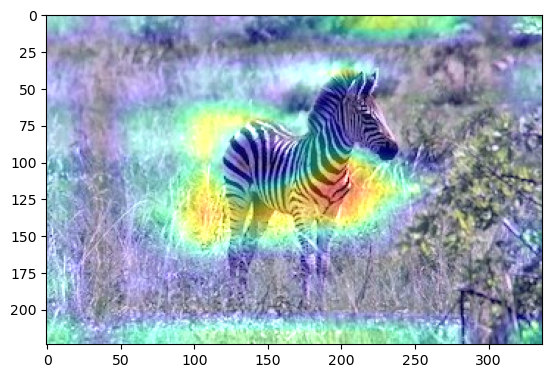

In [1]:
"""
Simple implementation of Grad-CAM (https://arxiv.org/pdf/1610.02391.pdf)
"""
import sys, os
sys.path.append(os.pardir)
sys.path.append(os.curdir)
import numpy as np
from PIL import Image
import cv2
import axon
import axon.functions as F
from axon.models import VGG16
import matplotlib.pyplot as plt


url = 'https://github.com/oreilly-japan/deep-learning-from-scratch-3/raw/images/zebra.jpg'
img_path = axon.io.get_file(url)
img = Image.open(img_path)
img_size = img.size

model = VGG16(pretrained=True)
x = VGG16.preprocess(img)[np.newaxis]  # preprocess for VGG
y = model(x)
last_conv_output = model.conv5_3.outputs[0]()
predict_id = np.argmax(y.data)
predict_output = y[0, predict_id]

predict_output.backward(retain_grad=True)
grads = last_conv_output.grad
pooled_grads = F.average(grads, axis=(0, 2, 3))

heatmap = last_conv_output.data[0]
for c in range(heatmap.shape[0]):
    heatmap[c] *= pooled_grads[c].data

heatmap = np.mean(heatmap, axis=0)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = axon.core.as_numpy(heatmap)

# visualize the heatmap on image
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

heatmap_on_img = cv2.addWeighted(heatmap, 0.4, img, 1.0, 0)
plt.imshow(cv2.cvtColor(heatmap_on_img, cv2.COLOR_BGR2RGB))
plt.show()